In [32]:
# %% [markdown]
# # LQR Controller for TVC Platform
# This cell defines the LQRController class, which is basically consistent with your previous Python version,
# except that main() is removed for interactive use in the notebook.

# %%
import numpy as np
import scipy.linalg
from dataclasses import dataclass

@dataclass
class PhyParams:
    MASS: float
    G: float
    I_XX: float
    I_YY: float
    I_ZZ: float
    DIST_COM_2_THRUST: float


class LQRController: 
    def __init__(self, phy_params: PhyParams):
        """
        LQR controller based on linearized TVC platform (consistent with your previous code).
        """
        if phy_params is None:
            raise ValueError("Physical parameters must be provided to initialize the LQR controller.")
        
        # Initialize system properties from physical parameters
        self.mass = phy_params.MASS
        self.gravity = phy_params.G
        self.I_XX = phy_params.I_XX
        self.I_YY = phy_params.I_YY
        self.I_ZZ = phy_params.I_ZZ
        self.dist_com_2_thrust = phy_params.DIST_COM_2_THRUST
        
        # System matrices
        self.A = self.set_A()
        assert self.A.shape == (12, 12), "Matrix A must be 12x12."
        
        self.B = self.set_B()
        assert self.B.shape == (12, 4), "Matrix B must be 12x4."
        
        # LQR weights & solution
        self.Q = None
        self.R = None
        self.P = None
        self.K = None

    # ---------- LQR Solution ----------
    def solve_lqr(self) -> bool:
        """
        Solve continuous-time LQR: A'P + P A - P B R^-1 B' P + Q = 0
        K = R^-1 B' P
        """
        if self.Q is None or self.R is None:
            raise ValueError("Q and R must be set before solving LQR.")
        try:
            self.P = scipy.linalg.solve_continuous_are(self.A, self.B, self.Q, self.R)
            # K = R^{-1} B^T P
            self.K = np.linalg.solve(self.R, self.B.T @ self.P)
            return True
        except Exception as e:
            print(f"Error solving LQR: {e}")
            self.K = None
            self.P = None
            return False

    def get_K(self) -> np.ndarray:
        """Return LQR gain K (4x12)"""
        return self.K

    def get_P(self) -> np.ndarray:
        """Return Riccati equation solution P (12x12)"""
        return self.P

    # ---------- System Matrix A ----------
    def set_A(self):
        """
        A matrix for linearized TVC/quadrotor-like model
        State: [x, y, z, vx, vy, vz, qx, qy, qz, p, q, r]
        """
        g = self.gravity
        A = np.array([
            [0, 0, 0, 1, 0, 0, 0, 0,   0,   0,   0,   0],   # x_dot = vx
            [0, 0, 0, 0, 1, 0, 0, 0,   0,   0,   0,   0],   # y_dot = vy
            [0, 0, 0, 0, 0, 1, 0, 0,   0,   0,   0,   0],   # z_dot = vz
            [0, 0, 0, 0, 0, 0, 0, -2*g, 0,  0,   0,   0],   # vx_dot ≈ -2g qy  (based on your original notation)
            [0, 0, 0, 0, 0, 0, 2*g,  0,  0,  0,   0,   0],   # vy_dot ≈  2g qx
            [0, 0, 0, 0, 0, 0, 0,  0,  0,  0,   0,   0],   # vz_dot, thrust/mass part is in B matrix
            [0, 0, 0, 0, 0, 0, 0,  0,  0,  0.5, 0,   0],   # qx_dot = p/2
            [0, 0, 0, 0, 0, 0, 0,  0,  0,  0,  0.5, 0],   # qy_dot = q/2
            [0, 0, 0, 0, 0, 0, 0,  0,  0,  0,   0,  0.5], # qz_dot = r/2
            [0, 0, 0, 0, 0, 0, 0,  0,  0,  0,   0,   0],  # p_dot
            [0, 0, 0, 0, 0, 0, 0,  0,  0,  0,   0,   0],  # q_dot
            [0, 0, 0, 0, 0, 0, 0,  0,  0,  0,   0,   0],  # r_dot
        ])
        return A

    # ---------- System Matrix B ----------
    def set_B(self):
        """
        Control input: u = [qx_cmd, qy_cmd, thrust_cmd, r_cmd]
        Corresponds to your original B matrix formulation.
        """
        g = self.gravity
        m = self.mass
        l = self.dist_com_2_thrust
        Ixx = self.I_XX
        Iyy = self.I_YY
        Izz = self.I_ZZ

        B = np.array([
            [0, 0, 0, 0],  # x
            [0, 0, 0, 0],  # y
            [0, 0, 0, 0],  # z
            [0,    -g, 0, 0],       # vx
            [g,     0, 0, 0],       # vy
            [0,     0, 1/m, 0],     # vz
            [0,     0, 0, 0],       # qx
            [0,     0, 0, 0],       # qy
            [0,     0, 0, 0],       # qz
            [-l*m*g/Ixx, 0, 0, 0],  # p
            [0, -l*m*g/Iyy, 0, 0],  # q
            [0,     0, 0, 1/Izz],   # r
        ])
        return B

    # ---------- Set Q / R ----------
    def set_Q(self, Q: np.ndarray) -> bool:
        if Q is None:
            return False
        Q = np.asarray(Q)
        if Q.shape != (12, 12):
            raise ValueError(f"Q must be 12x12, got {Q.shape}")
        self.Q = Q
        return True

    def set_R(self, R: np.ndarray) -> bool:
        if R is None:
            return False
        R = np.asarray(R)
        if R.shape != (4, 4):
            raise ValueError(f"R must be 4x4, got {R.shape}")
        self.R = R
        return True


In [33]:
# %% [markdown]
# ## Parameter Definition (corresponding to default values in load_parameters)

# %%
# Physical parameters (from load_parameters default values)
phy_params = PhyParams(
    MASS=0.6570,
    G=9.81,
    I_XX=0.062796,
    I_YY=0.062976,
    I_ZZ=0.001403,
    DIST_COM_2_THRUST=0.5693,
)

# LQR Q, R diagonal (from default_Q / default_R in load_parameters)
Q_diagonal = np.array([1.0, 1.0, 1.0,
                       1.0, 1.0, 1.0,
                       1.0, 1.0, 0.1,
                       1.0, 1.0, 0.01])

R_diagonal = np.array([10.0, 10.0, 1.0, 10.0])

Q_matrix = np.diag(Q_diagonal)
R_matrix = np.diag(R_diagonal)

# Target state (consistent with target in ROS2)
# target.position = [0, 0, 3]
target_position = np.array([3.0, 3.0, 3.0])
# target.velocity = [0, 0, 0]
target_velocity = np.array([0.0, 0.0, 0.0])
# target.orientation quaternion = [qx, qy, qz, qw] = [0, 0, 0, 1]
target_quaternion = np.array([0.0, 0.0, 0.0, 1.0])
# target.angular_velocity = [p, q, r] = [0, 0, 0]
target_angular_velocity = np.array([0.0, 0.0, 0.0])

# Note: LQR state is 12-dimensional, does not include q_w, only uses [qx, qy, qz]
x_ref = np.concatenate([
    target_position,        # x, y, z
    target_velocity,        # vx, vy, vz
    target_quaternion[:3],  # qx, qy, qz
    target_angular_velocity # p, q, r
])
print("x_ref shape:", x_ref.shape)
print("x_ref:", x_ref)

# Control input constraints (from config file)
# Thrust deflection angle limits (radians)
servo_0_min = -0.25  # qx_cmd minimum value
servo_0_max = 0.25   # qx_cmd maximum value
servo_1_min = -0.25  # qy_cmd minimum value
servo_1_max = 0.25   # qy_cmd maximum value

# Total thrust limits (N)
# Note: In actual code, thrust_without_gravity = u_lqr[2] - MASS * G
# The limits are applied to thrust_without_gravity, not directly to u_lqr[2]
# In FRD frame, downward is positive, so:
# - Minimum net thrust: -1.5 * G (upward thrust, negative in FRD)
# - Maximum net thrust: 0.1 * MASS * G (downward thrust, positive in FRD)
thrust_min_g_multiplier = -1.5  # Minimum net thrust as multiplier of G
thrust_max_weight_fraction = 0.1  # Maximum net thrust as fraction of weight

# Net thrust limits (after subtracting gravity)
thrust_net_min = thrust_min_g_multiplier * phy_params.G  # Minimum net thrust (N)
thrust_net_max = phy_params.MASS * phy_params.G * thrust_max_weight_fraction  # Maximum net thrust (N)

# If we want to limit u_lqr[2] directly, we need to add back the gravity:
# u_lqr[2] = thrust_without_gravity + MASS * G
thrust_cmd_min = thrust_net_min + phy_params.MASS * phy_params.G  # Minimum total thrust command
thrust_cmd_max = thrust_net_max + phy_params.MASS * phy_params.G  # Maximum total thrust command

# Yaw torque limits (Nm)
# Note: In actual code, r_cmd (u_lqr[3]) is directly limited as torque command
torque_z_min = -0.5  # Minimum torque corresponding to r_cmd (Nm)
torque_z_max = 0.5   # Maximum torque corresponding to r_cmd (Nm)
r_cmd_min = torque_z_min  # r_cmd is directly a torque value
r_cmd_max = torque_z_max

print("\nControl Input Constraints:")
print(f"  qx_cmd (thrust deflection angle): [{servo_0_min:.3f}, {servo_0_max:.3f}] rad")
print(f"  qy_cmd (thrust deflection angle): [{servo_1_min:.3f}, {servo_1_max:.3f}] rad")
print(f"  Net thrust (after gravity): [{thrust_net_min:.2f}, {thrust_net_max:.2f}] N")
print(f"  thrust_cmd (total thrust command): [{thrust_cmd_min:.2f}, {thrust_cmd_max:.2f}] N")
print(f"  r_cmd (yaw torque): [{r_cmd_min:.3f}, {r_cmd_max:.3f}] Nm")


x_ref shape: (12,)
x_ref: [3. 3. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Control Input Constraints:
  qx_cmd (thrust deflection angle): [-0.250, 0.250] rad
  qy_cmd (thrust deflection angle): [-0.250, 0.250] rad
  Net thrust (after gravity): [-14.71, 0.64] N
  thrust_cmd (total thrust command): [-8.27, 7.09] N
  r_cmd (yaw torque): [-0.500, 0.500] Nm


In [34]:
# %% [markdown]
# ## Construct LQR Controller and Solve

# %%
lqr = LQRController(phy_params)

# Set Q, R
lqr.set_Q(Q_matrix)
lqr.set_R(R_matrix)

# Solve LQR
success = lqr.solve_lqr()
print("LQR solve success:", success)

K = lqr.get_K()
P = lqr.get_P()

print("K shape:", K.shape)
print("K =\n", K)

# %% [markdown]
# ## Simple Control Test: from x(0)=0 to x_ref

# %%
# Initial state x(0) = 0
x0 = np.zeros(12)

# State error e = x - x_ref (your original code used X_i - X_f)
e = x0 - x_ref

# Control law u = -K * e
u = -K @ e

print("Initial state x0:", x0)
print("Reference state x_ref:", x_ref)
print("State error e = x0 - x_ref:", e)
print("Control input u = -K e:", u)


LQR solve success: True
K shape: (4, 12)
K =
 [[ 1.05048318e-15 -3.16227766e-01  2.78144877e-16  1.92005487e-15
  -4.85568773e-01 -5.72850923e-17 -4.21206749e+00 -1.89478517e-14
   1.11509926e-16 -4.97560245e-01 -6.92810034e-16  2.41620350e-17]
 [ 3.16227766e-01 -8.31008121e-16 -2.01020241e-16  4.85646455e-01
  -1.93788490e-15 -9.49730335e-17 -1.50281678e-14 -4.21440799e+00
   1.19922552e-16 -6.93823311e-16 -4.98110408e-01  4.46843625e-18]
 [-1.68176915e-16  1.91991750e-16  1.00000000e+00 -1.31490498e-16
   9.85889523e-17  1.52118375e+00  4.27373069e-16  6.92095651e-16
   7.90775784e-17  3.14743155e-17  4.69496884e-17  1.12929862e-18]
 [-4.05109487e-16 -8.08042964e-16  7.61030413e-17 -2.16519211e-16
  -7.97007589e-16  5.28830503e-17 -5.83804109e-15 -2.41238621e-16
   1.00000000e-01 -4.28545160e-16 -1.82078374e-17  3.37683284e-02]]
Initial state x0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Reference state x_ref: [3. 3. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
State error e = x0 - x_ref: [-3. -3. -3.

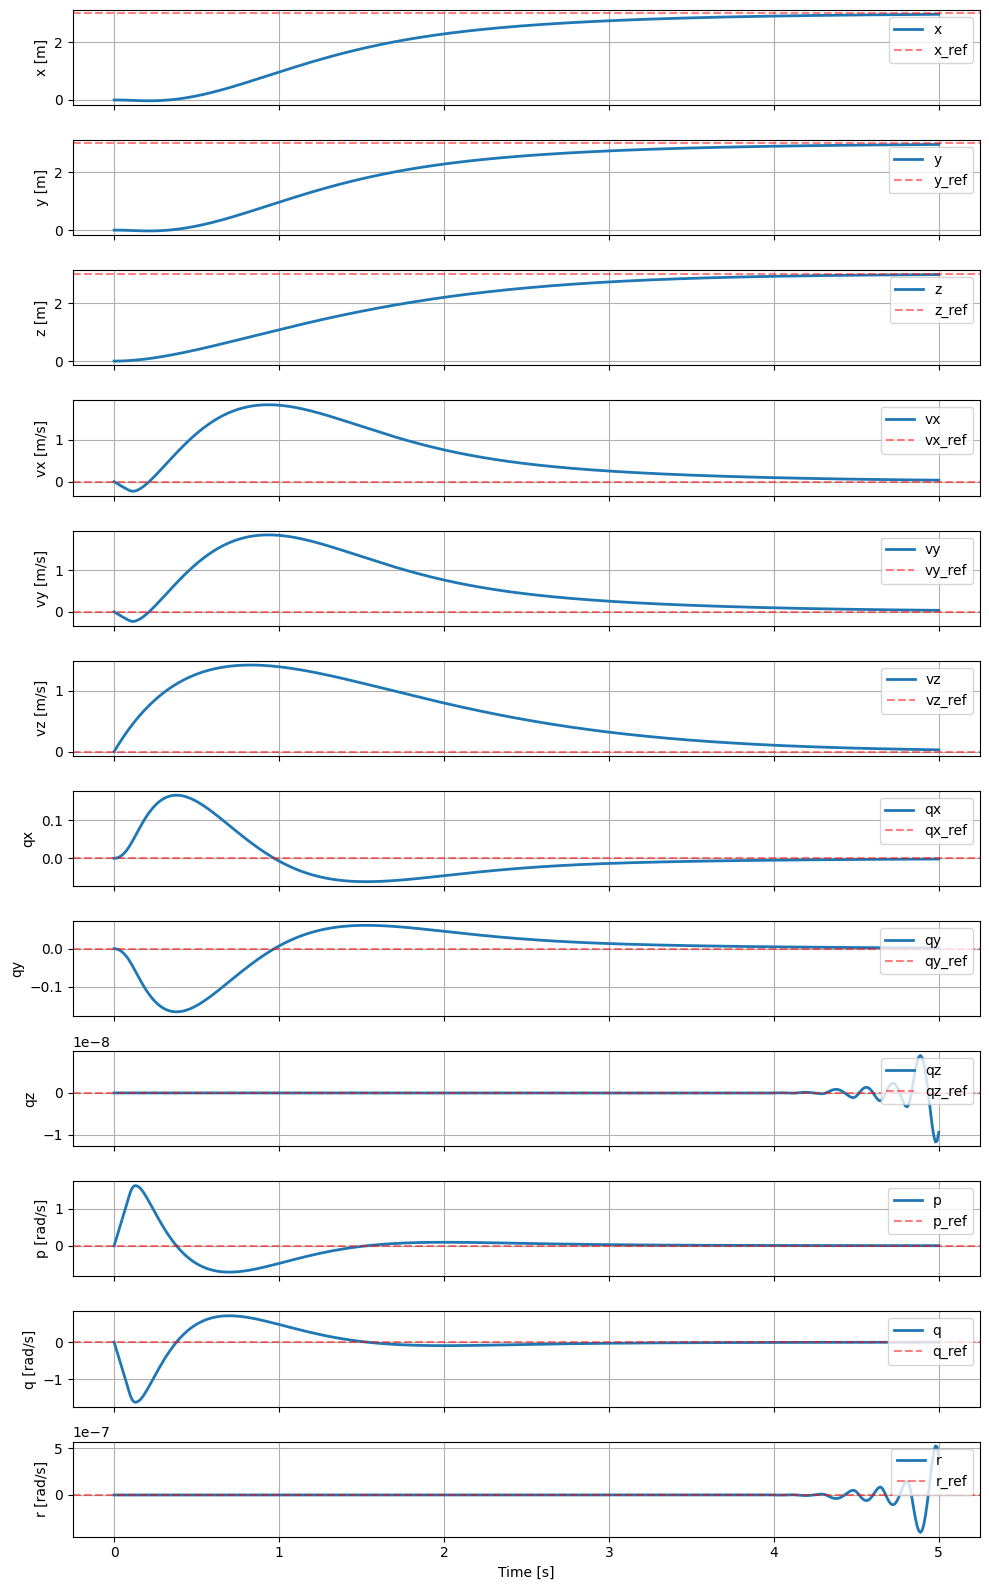

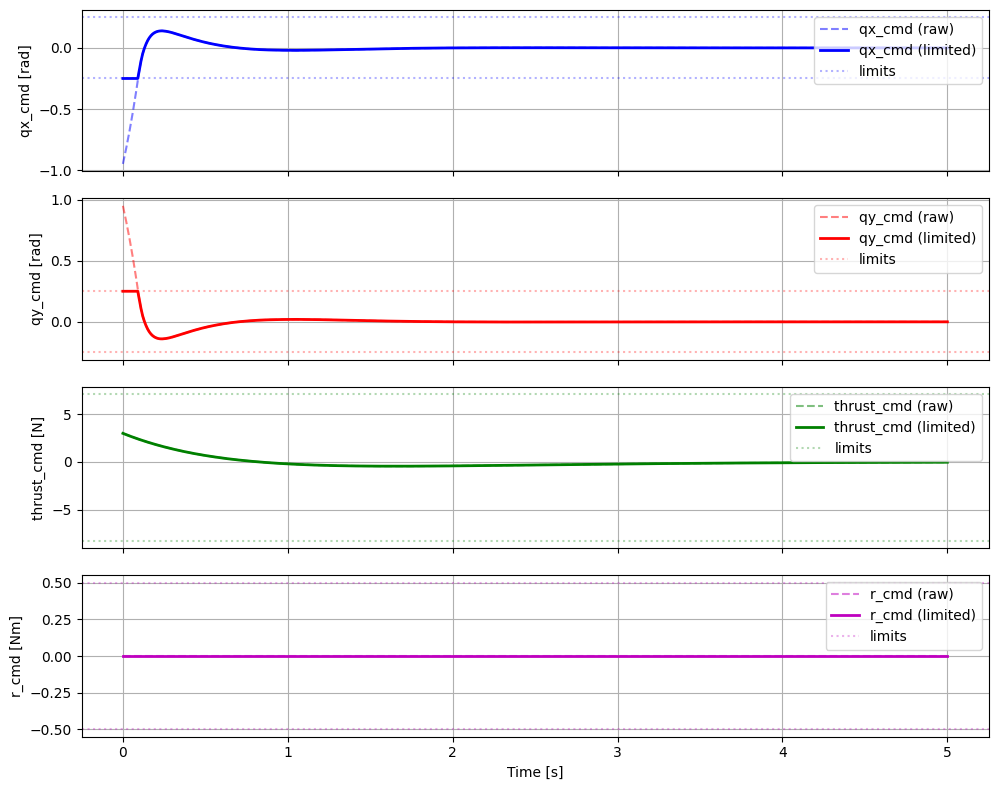

In [ ]:
# %% [markdown]
# ## Optional: Simple Closed-Loop Simulation (Continuous-Time Linear System)

# %%
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

A = lqr.A
B = lqr.B

# Simulation with control input constraints
# Use open-loop system: x_dot = A x + B u, where u is the limited control input
# This accurately simulates the system behavior with actuator constraints

def system_dynamics_with_limited_control(t, x):
    """
    System dynamics using limited control inputs.
    x_dot = A @ x + B @ u_limited
    where u_limited is computed from LQR law with constraints applied.
    """
    # Compute error
    e = x - x_ref
    
    # Compute LQR control law
    u_raw = -K @ e
    
    # Apply control input constraints
    # 1. Thrust deflection angle limits
    u_limited = np.zeros(4)
    u_limited[0] = np.clip(u_raw[0], servo_0_min, servo_0_max)  # qx_cmd
    u_limited[1] = np.clip(u_raw[1], servo_1_min, servo_1_max)  # qy_cmd
    
    # 2. Total thrust limits
    # In actual code: thrust_without_gravity = u_lqr[2] - MASS * G
    # Then limit thrust_without_gravity, and convert back to u_lqr[2]
    thrust_without_gravity = u_raw[2] - phy_params.MASS * phy_params.G
    thrust_without_gravity_limited = np.clip(thrust_without_gravity, thrust_net_min, thrust_net_max)
    u_limited[2] = thrust_without_gravity_limited + phy_params.MASS * phy_params.G  # thrust_cmd
    
    # 3. Yaw torque limits
    u_limited[3] = np.clip(u_raw[3], r_cmd_min, r_cmd_max)  # r_cmd
    
    # System dynamics: x_dot = A @ x + B @ u_limited
    return A @ x + B @ u_limited

# Initial state: x(0) = x0
x0 = np.zeros(12)

t_span = (0.0, 5.0)         # Simulate for 5 seconds
t_eval = np.linspace(t_span[0], t_span[1], 500)

# Simulate with limited control inputs
sol = solve_ivp(system_dynamics_with_limited_control, t_span, x0, t_eval=t_eval)

# Recover state trajectory
x_traj = sol.y.T            # shape: (N, 12)
e_traj = x_traj - x_ref     # Error trajectory

# Calculate control inputs (raw and limited) at each time step
u_traj = np.zeros((len(sol.t), 4))  # shape: (N, 4)
u_traj_limited = np.zeros((len(sol.t), 4))  # Limited control inputs
for i in range(len(sol.t)):
    e = e_traj[i]
    u_raw = -K @ e
    u_traj[i] = u_raw
    
    # Apply control input constraints (same as in dynamics function)
    u_traj_limited[i, 0] = np.clip(u_raw[0], servo_0_min, servo_0_max)  # qx_cmd
    u_traj_limited[i, 1] = np.clip(u_raw[1], servo_1_min, servo_1_max)  # qy_cmd
    
    thrust_without_gravity = u_raw[2] - phy_params.MASS * phy_params.G
    thrust_without_gravity_limited = np.clip(thrust_without_gravity, thrust_net_min, thrust_net_max)
    u_traj_limited[i, 2] = thrust_without_gravity_limited + phy_params.MASS * phy_params.G  # thrust_cmd
    
    u_traj_limited[i, 3] = np.clip(u_raw[3], r_cmd_min, r_cmd_max)  # r_cmd

# Plot all states grouped: position, velocity, attitude, angular velocity, and control inputs
fig, axs = plt.subplots(5, 1, figsize=(10, 12), sharex=True)

# Position states (x, y, z)
axs[0].plot(sol.t, x_traj[:, 0], label='x', linewidth=2)
axs[0].plot(sol.t, x_traj[:, 1], label='y', linewidth=2)
axs[0].plot(sol.t, x_traj[:, 2], label='z', linewidth=2)
axs[0].axhline(x_ref[0], linestyle='--', color='r', alpha=0.5, label='x_ref')
axs[0].axhline(x_ref[1], linestyle='--', color='g', alpha=0.5, label='y_ref')
axs[0].axhline(x_ref[2], linestyle='--', color='b', alpha=0.5, label='z_ref')
axs[0].set_ylabel('Position [m]')
axs[0].legend(loc='upper right', ncol=2)
axs[0].grid(True)

# Velocity states (vx, vy, vz)
axs[1].plot(sol.t, x_traj[:, 3], label='vx', linewidth=2)
axs[1].plot(sol.t, x_traj[:, 4], label='vy', linewidth=2)
axs[1].plot(sol.t, x_traj[:, 5], label='vz', linewidth=2)
axs[1].axhline(x_ref[3], linestyle='--', color='r', alpha=0.5, label='vx_ref')
axs[1].axhline(x_ref[4], linestyle='--', color='g', alpha=0.5, label='vy_ref')
axs[1].axhline(x_ref[5], linestyle='--', color='b', alpha=0.5, label='vz_ref')
axs[1].set_ylabel('Velocity [m/s]')
axs[1].legend(loc='upper right', ncol=2)
axs[1].grid(True)

# Attitude states (qx, qy, qz)
axs[2].plot(sol.t, x_traj[:, 6], label='qx', linewidth=2)
axs[2].plot(sol.t, x_traj[:, 7], label='qy', linewidth=2)
axs[2].plot(sol.t, x_traj[:, 8], label='qz', linewidth=2)
axs[2].axhline(x_ref[6], linestyle='--', color='r', alpha=0.5, label='qx_ref')
axs[2].axhline(x_ref[7], linestyle='--', color='g', alpha=0.5, label='qy_ref')
axs[2].axhline(x_ref[8], linestyle='--', color='b', alpha=0.5, label='qz_ref')
axs[2].set_ylabel('Attitude (quaternion)')
axs[2].legend(loc='upper right', ncol=2)
axs[2].grid(True)

# Angular velocity states (p, q, r)
axs[3].plot(sol.t, x_traj[:, 9], label='p', linewidth=2)
axs[3].plot(sol.t, x_traj[:, 10], label='q', linewidth=2)
axs[3].plot(sol.t, x_traj[:, 11], label='r', linewidth=2)
axs[3].axhline(x_ref[9], linestyle='--', color='r', alpha=0.5, label='p_ref')
axs[3].axhline(x_ref[10], linestyle='--', color='g', alpha=0.5, label='q_ref')
axs[3].axhline(x_ref[11], linestyle='--', color='b', alpha=0.5, label='r_ref')
axs[3].set_ylabel('Angular Velocity [rad/s]')
axs[3].legend(loc='upper right', ncol=2)
axs[3].grid(True)

# Control inputs (before and after limiting)
axs[4].plot(sol.t, u_traj[:, 0], 'b--', alpha=0.5, label='qx_cmd (raw)')
axs[4].plot(sol.t, u_traj[:, 1], 'r--', alpha=0.5, label='qy_cmd (raw)')
axs[4].plot(sol.t, u_traj[:, 2], 'g--', alpha=0.5, label='thrust_cmd (raw)')
axs[4].plot(sol.t, u_traj[:, 3], 'm--', alpha=0.5, label='r_cmd (raw)')

axs[4].plot(sol.t, u_traj_limited[:, 0], 'b-', linewidth=2, label='qx_cmd (limited)')
axs[4].plot(sol.t, u_traj_limited[:, 1], 'r-', linewidth=2, label='qy_cmd (limited)')
axs[4].plot(sol.t, u_traj_limited[:, 2], 'g-', linewidth=2, label='thrust_cmd (limited)')
axs[4].plot(sol.t, u_traj_limited[:, 3], 'm-', linewidth=2, label='r_cmd (limited)')

# Plot constraint lines
axs[4].axhline(servo_0_min, color='b', linestyle=':', alpha=0.3)
axs[4].axhline(servo_0_max, color='b', linestyle=':', alpha=0.3)
axs[4].axhline(servo_1_min, color='r', linestyle=':', alpha=0.3)
axs[4].axhline(servo_1_max, color='r', linestyle=':', alpha=0.3)
axs[4].axhline(thrust_cmd_min, color='g', linestyle=':', alpha=0.3)
axs[4].axhline(thrust_cmd_max, color='g', linestyle=':', alpha=0.3)
axs[4].axhline(r_cmd_min, color='m', linestyle=':', alpha=0.3)
axs[4].axhline(r_cmd_max, color='m', linestyle=':', alpha=0.3)

axs[4].set_ylabel('Control Input')
axs[4].set_xlabel('Time [s]')
axs[4].legend(loc='upper right', fontsize=8, ncol=2)
axs[4].grid(True)

plt.tight_layout()
plt.show()
